## ML Prediction: Titanic Survival 

The final project is to enter the Kaggle "competition" regarding a Titanic dataset. You will need to create a Kaggle account in order to make a submission. 

Your model should predict survival given features in the dataset. Use a random forest model with either a minimum samples per leaf (preferred) or maximum depth limit. Evaluate different values for this parameter using cross validation. Remember that categorical columns will need to either be converted to 1's and 0's (if binary) or dummy-coded (if there are more than 2 categories).

Your model should include the fare column and it should be clustered into four groups using k-means clustering. The numbers assigned to the clusters may not correspond to their order, so you will then have to either renumber them in some principled way or dummy code them.

You should experiment with different sets of features, you don't need to included all of them. I encourage you to check out the kernels that are posted and read through some of them. 

Once you have trained a model you are satisfied with then create a csv file of your predictions on the test set. Submit that file to Kaggle and then document your score in your code on the Python server.

In [62]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

In [63]:
train = pd.read_csv('/share/Datasets/Kaggle Titanic/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
test = pd.read_csv('/share/Datasets/Kaggle Titanic/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Finding null values and filling them in with mean or median appropriately if null values are present:

In [65]:
train["Sex"].isnull().any()

False

In [66]:
train["Age"].isnull().any()

True

In [67]:
agemean = train["Age"].mean()
train["Age"].fillna(value=agemean, inplace=True)
test["Age"].fillna(value=agemean, inplace=True)

In [68]:
test["Fare"].isnull().any()

True

In [69]:
faremean = train["Fare"].median()
train["Fare"].fillna(value=faremean, inplace=True)
test["Fare"].fillna(value=faremean, inplace=True)

### Trying to see if Cabin variable also plays a role in survival, assuming that people of recorded cabin number were of higher socio economic class. 
### Finally, creating a boolean function where cabins with recorded numbers is labeled as 1 and without a recorded number as 0. 

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085


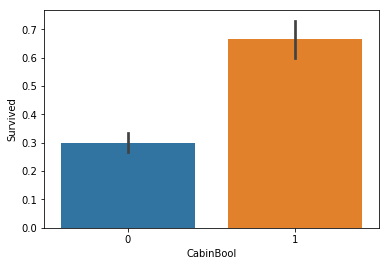

In [70]:

train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

#calculate percentages of CabinBool vs. survived
print("Percentage of CabinBool = 1 who survived:", train["Survived"][train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", train["Survived"][train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
#draw a bar plot of CabinBool vs. survival
sns.barplot(x="CabinBool", y="Survived", data=train)
plt.show()

### As predicted, cabins with recorded numbers on them (higher socio economic class assumed for our analysis), have a higher rate of survival, thus we will use this new variable for our modeling as well. 

In [71]:
features = train.loc[:,["Pclass","Sex","Age","SibSp","Parch","Fare","CabinBool"]]
targets = train.loc[:,"Survived"]
test_features = test.loc[:,["Pclass","Sex","Age","SibSp","Parch","Fare","CabinBool"]]
features.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,CabinBool
0,3,male,22.0,1,0,7.2500,0
1,1,female,38.0,1,0,71.2833,1
2,3,female,26.0,0,0,7.9250,0
3,1,female,35.0,1,0,53.1000,1
4,3,male,35.0,0,0,8.0500,0


### Dummy coding 'Sex' feature into 'female' and 'male' for both features and targets:

In [72]:
sex_dc = pd.get_dummies(features["Sex"])
features2 = pd.concat([features, sex_dc], axis=1)
features1 = features2.drop(columns = ["Sex"], axis = 1) 
features1.head()


,Pclass,Age,SibSp,Parch,Fare,CabinBool,female,male
0,3,22.0,1,0,7.2500,0,0,1
1,1,38.0,1,0,71.2833,1,1,0
2,3,26.0,0,0,7.9250,0,1,0
3,1,35.0,1,0,53.1000,1,1,0
4,3,35.0,0,0,8.0500,0,0,1


In [73]:
sex_dc1 = pd.get_dummies(test_features["Sex"])
test_features2 = pd.concat([test_features, sex_dc1], axis=1)
test_features1 = test_features2.drop(columns = ["Sex"], axis = 1) 
test_features1.head()


,Pclass,Age,SibSp,Parch,Fare,CabinBool,female,male
0,3,34.5,0,0,7.8292,0,0,1
1,3,47.0,1,0,7.0000,0,1,0
2,2,62.0,0,0,9.6875,0,0,1
3,3,27.0,0,0,8.6625,0,0,1
4,3,22.0,1,1,12.2875,0,1,0


### Clustering 'fare' feature into 4 clusters and dummy coding them into '0' '1' '2' and'3' for both features1 (training set) and test_features1 (testing set):  

In [74]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(features1.iloc[:,4:5])
test_kmeans = KMeans(n_clusters=4, random_state=0).fit(test_features1.iloc[:,4:5])

In [75]:
kmeans.labels_

array([0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0,

In [76]:
test_kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,

In [77]:
features1['faredc'] = kmeans.labels_
features1.head()

,Pclass,Age,SibSp,Parch,Fare,CabinBool,female,male,faredc
0,3,22.0,1,0,7.2500,0,0,1,0
1,1,38.0,1,0,71.2833,1,1,0,2
2,3,26.0,0,0,7.9250,0,1,0,0
3,1,35.0,1,0,53.1000,1,1,0,2
4,3,35.0,0,0,8.0500,0,0,1,0


In [78]:
test_features1['faredc'] = test_kmeans.labels_
test_features1.head()

,Pclass,Age,SibSp,Parch,Fare,CabinBool,female,male,faredc
0,3,34.5,0,0,7.8292,0,0,1,0
1,3,47.0,1,0,7.0000,0,1,0,0
2,2,62.0,0,0,9.6875,0,0,1,0
3,3,27.0,0,0,8.6625,0,0,1,0
4,3,22.0,1,1,12.2875,0,1,0,0


In [79]:
features1_faredc = pd.get_dummies(features1['faredc'])
test_features1_faredc = pd.get_dummies(test_features1['faredc'])

In [80]:
features1 = pd.concat([features1, features1_faredc], axis=1)
test_features1 = pd.concat([test_features1, test_features1_faredc], axis=1)

In [81]:
features1 = features1.drop(columns = ["Fare","faredc"], axis = 1) 
features1.head()

,Pclass,Age,SibSp,Parch,CabinBool,female,male,0,1,2,3
0,3,22.0,1,0,0,0,1,1,0,0,0
1,1,38.0,1,0,1,1,0,0,0,1,0
2,3,26.0,0,0,0,1,0,1,0,0,0
3,1,35.0,1,0,1,1,0,0,0,1,0
4,3,35.0,0,0,0,0,1,1,0,0,0


In [82]:
test_features1 = test_features1.drop(columns = ["Fare","faredc"], axis = 1) 
test_features1.head()

,Pclass,Age,SibSp,Parch,CabinBool,female,male,0,1,2,3
0,3,34.5,0,0,0,0,1,1,0,0,0
1,3,47.0,1,0,0,1,0,1,0,0,0
2,2,62.0,0,0,0,0,1,1,0,0,0
3,3,27.0,0,0,0,0,1,1,0,0,0
4,3,22.0,1,1,0,1,0,1,0,0,0


### Building a random forest classifier (forest1) with minimum samples leaf of 5 and printing out the scores of interest:

In [88]:
forest1 = RandomForestClassifier(n_estimators=40, min_samples_leaf=5)
scoring = ['accuracy','precision', 'recall', 'f1']
scores = cross_validate(forest1, features1, targets, scoring=scoring, cv=5)
print("Accuracy", scores['test_accuracy'])
print("Precision", scores['test_precision'])
print("Recall", scores['test_recall'])
print("F1", scores['test_f1'])

Accuracy [0.79888268 0.81564246 0.8258427  0.78089888 0.83050847]
Precision [0.76190476 0.78125    0.80327869 0.79591837 0.796875  ]
Recall [0.69565217 0.72463768 0.72058824 0.57352941 0.75      ]
F1 [0.72727273 0.7518797  0.75968992 0.66666667 0.77272727]


### Building a random forest classifier (forest2) with a higher minimum samples leaf of 15 and printing out the scores of interest: 

In [89]:
forest2 = RandomForestClassifier(n_estimators=40, min_samples_leaf=15)
scoring = ['accuracy','precision', 'recall', 'f1']
scores = cross_validate(forest2, features1, targets, scoring=scoring, cv=5)
print("Accuracy", scores['test_accuracy'])
print("Precision", scores['test_precision'])
print("Recall", scores['test_recall'])
print("F1", scores['test_f1'])

Accuracy [0.82122905 0.81005587 0.80337079 0.75842697 0.81355932]
Precision [0.83636364 0.78688525 0.78947368 0.72727273 0.81818182]
Recall [0.66666667 0.69565217 0.66176471 0.58823529 0.66176471]
F1 [0.74193548 0.73846154 0.72       0.6504065  0.73170732]


### Applying the second model to predict values on the test set and finally building a result set with the passengergrid and the predicted survived column: 

In [85]:
fitmodel = forest2.fit(features1, targets)
preds = fitmodel.predict(test_features1)
result = pd.DataFrame(test["PassengerId"])
result["Survived"] = preds
result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [86]:
result.to_csv('~/result.csv', sep=",", index = False)

### After I entered the CSV file in Kaggle's Titanic Competition, I got a score of 0.77511 the image of which is posted below:

<img src="https://testhollinsuniversity-my.sharepoint.com/:i:/r/personal/bhattaraig_hollins_edu/Documents/Data%20and%20Coding%20Portfolio/a.png?csf=1&web=1&e=gkyYvf" style="float: right;" alt="Wait Time: 1 seconds, Execution Time: 0 seconds, Score: 0.77511"/>

